# Import libraries

First we import the libraries to use them later

In [1]:
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.2 MB/s eta 0:00:00


In [2]:
import os
import cv2
import time
import math
import glob
import seaborn
import visualkeras
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from PIL import ImageFont
from tensorflow import keras
from google.colab import files
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report

# Download and create dataset

in this section we download the dataset from:<br> https://figshare.com/articles/dataset/GRAZPEDWRI-DX/14825193

In [3]:
# Download the first file # csv file
!curl -O -J -L "https://ndownloader.figshare.com/files/35026432"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1807k  100 1807k    0     0  1034k      0  0:00:01  0:00:01 --:--:-- 3688k


In [4]:
# Download the second file #
!curl -O -J -L "https://ndownloader.figshare.com/files/34268819"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25.0M  100 25.0M    0     0   9.9M      0  0:00:02  0:00:02 --:--:-- 23.2M


In [5]:
# Download the third file #
!curl -O -J -L "https://ndownloader.figshare.com/files/34268828"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3859M  100 3859M    0     0  29.0M      0  0:02:12  0:02:12 --:--:-- 30.0M


In [6]:
# Download the fourth file #
!curl -O -J -L "https://ndownloader.figshare.com/files/34268849"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3931M  100 3931M    0     0  29.5M      0  0:02:13  0:02:13 --:--:-- 30.0M


In [7]:
# Download the fifth file #
!curl -O -J -L "https://ndownloader.figshare.com/files/34268864"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3672M  100 3672M    0     0  28.6M      0  0:02:08  0:02:08 --:--:-- 29.5M


In [8]:
# Download the sixth file #
!curl -O -J -L "https://ndownloader.figshare.com/files/34268891"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4012M  100 4012M    0     0  29.2M      0  0:02:17  0:02:17 --:--:-- 29.7M


in the next step, we extract all the images

In [ ]:
# Your code here #
!for i in {1..4}; do unzip /content/images_part${i}.zip -d /content/dataset; done

Next, due to disk limitations, we delete all zip files

In [10]:
# Your code here #
directory = '/content'

for filename in os.listdir(directory):
    if filename.endswith('.zip'):
        file_path = os.path.join(directory, filename)
        os.remove(file_path)

# Read csv file

In the csv file, we only need the filestem and fracture_visible columns. Here is a description of them:

*   <b>filestem:<br> </b> the name of images (note that we should add 'png' to them)
*   <b>fracture_visible: </b> <br> image labels (note that the labels are binary and we replace 'Nan' values with '0') <br>
---
As it is clear from the csv file, we have 20327 photos







In [ ]:
# Your code here #

# Read the CSV file
df = pd.read_csv('dataset.csv')

# Add 'png' extension to filestem
df['filestem'] = df['filestem'].apply(lambda x: x + '.png')

# Replace 'NaN' values in fracture_visible with '0'
df['fracture_visible'].fillna('0', inplace=True)

# Convert fracture_visible to float and round to 1 decimal place
df['fracture_visible'] = df['fracture_visible'].astype(float).round(1)

# Select only the 'filestem' and 'fracture_visible' columns
df_selected = df[['filestem', 'fracture_visible']]

# Save the modified DataFrame to a new CSV file
df_selected.to_csv('modified_file.csv', index=False)

# Print the modified DataFrame
print(df_selected)

# Create dataloader

Our images are grayscale so we convert them to RGB becase the models input must have three channels.<br> Then we resize the images to (224,224,3) becuase all input images must be the same size.

In [12]:
size = 224
image_dir = 'dataset/'

for f in df['filestem']:
    if f[-3:] == 'jpg' or f[-3:] == 'png':
        # Load the grayscale image
        image_path = os.path.join(image_dir, f)
        image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Resize image
        image_resized = cv2.resize(image_gray, (size, size))

        # Convert grayscale image to RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

        # Save the RGB image with the same filename
        cv2.imwrite(image_path, image_rgb)

Due to RAM limitations, we should use dataloader and batch size.<br> Here is some information about data after the dataloader is created:

*   <b> Image shape: </b> (224, 224, 3)
*   <b> Number of channels: </b> 3
*   <b> Channel format: </b> RGB
*   <b> Data scale: </b> 0 to 1
*   <b> Batch size: </b> 64
*   <b> Validation size: </b> 20%
*   <b> Data type: </b> float32








In [62]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Image directory
image_dir = 'dataset/'

# Image shape
image_shape = (224, 224, 3)

# Batch size
batch_size = 64

# Validation size
validation_size = 0.2

# Data scale
data_scale = 1.0 / 255.0

# Load the dataframe from CSV file
df = pd.read_csv('/content/modified_file.csv')

# Convert label column to string
df['fracture_visible'] = df['fracture_visible'].astype(str)
print(df['fracture_visible'])

# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=validation_size, random_state=42)

# Create an ImageDataGenerator for data processing and augmentation
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=data_scale  # Scale the pixel values between 0 and 1
)

# Create the train and validation generators
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filestem',  # Column containing the image filenames
    y_col='fracture_visible',  # Column containing the image labels
    target_size=image_shape[:2],  # Resize the images to the target shape
    color_mode='rgb',  # RGB channel format
    batch_size=batch_size,
    shuffle=True
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filestem',
    y_col='fracture_visible',
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    shuffle=False
)

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
20322    0.0
20323    0.0
20324    0.0
20325    1.0
20326    1.0
Name: fracture_visible, Length: 20327, dtype: object
Found 16261 validated image filenames belonging to 2 classes.
Found 4066 validated image filenames belonging to 2 classes.


In [63]:
# Print the labels of training data
print(train_generator.labels)

# Print the labels of validation data
print(val_generator.labels)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 

In [64]:
train_size = train_generator.samples
validation_size = val_generator.samples

# plot some images

In this section we show some images and their labels with matplotlib library

In [67]:
def visualize(data,figsize,shape):
    '''
      visualize some samples
      input(s):
        data (int): The dataset we want to show some examples of
        figsize (tuple): size of images for display
        shape (tuple): number of images for display
      output(s):
        visualize some samples
    '''

    # obtain one batch of training images
    dataiter = iter(data)
    images, labels = next(dataiter)

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=figsize)
    x,y = shape
    for idx in np.arange(x*y):
        ax = fig.add_subplot(x, y, idx+1, xticks=[], yticks=[])
        print(images[idx].shape)
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        ax.set_title(str(labels[idx].argmax()))

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


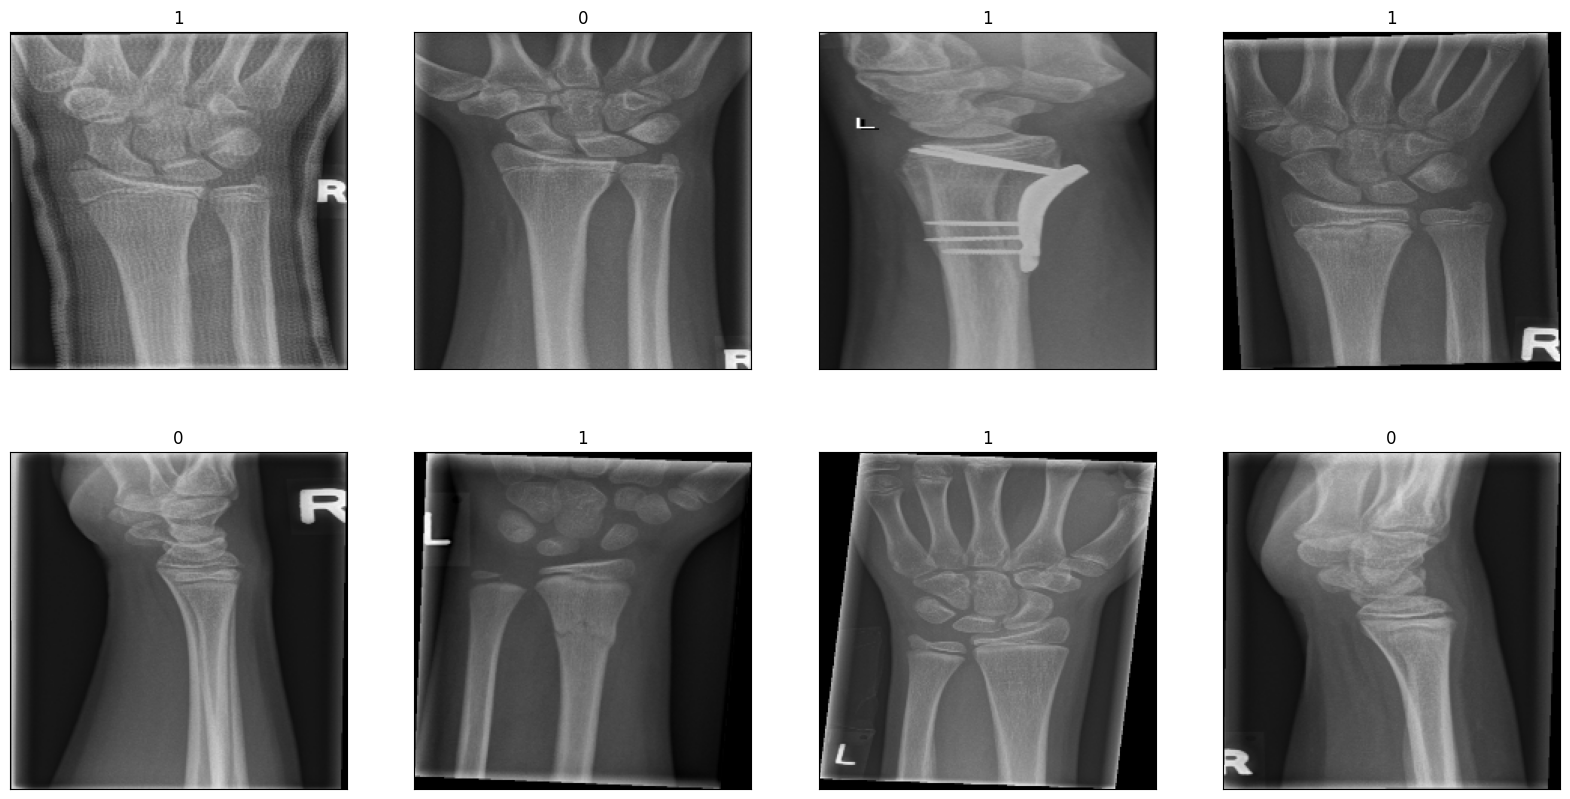

In [68]:
visualize(train_generator,(20,10),(2,4))

# Define models

We use transfer learning with imagenet weights for training our models.<br> We fine tune the last two layers and use a multi layer perceptron(MLP) with a hidden layer of size 128 and two neurons in the last layer for prediction. <br> Also we use Categorical CrossEntropy as the loss function and Adam as the optimizer. <br> 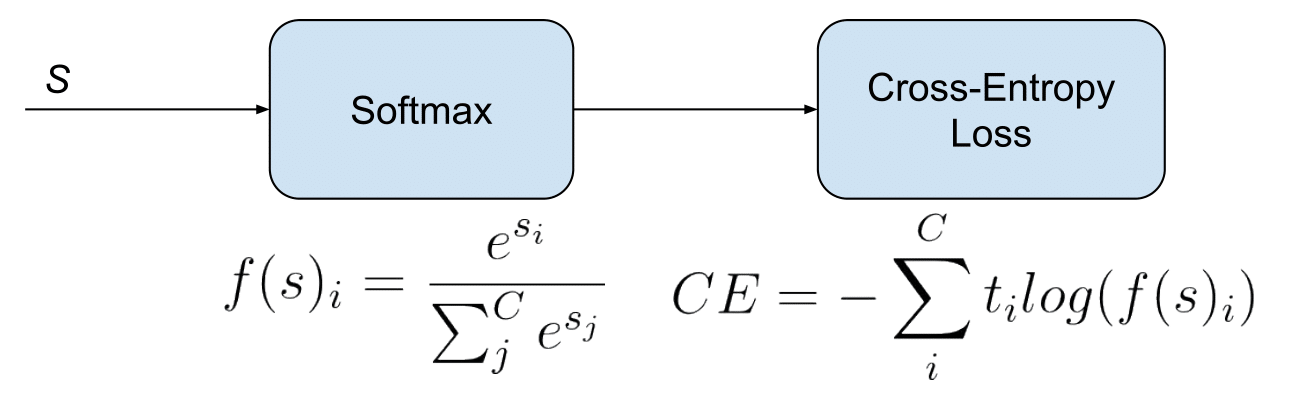

in this section we define a function that takes `conv_model` as input and we want to fine-tune our model.

Note: please tune the last two layers of the conv model and then create a mlp with 128 hidden layer and `relu` function for activation.

In [75]:
import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense,Flatten

def define_model(conv_model):
    # Fine-tune the last two layers of the conv model
    for layer in conv_model.layers[:-2]:
        layer.trainable = False

    # Create the MLP (fully connected) layers
    x = GlobalAveragePooling2D()(conv_model.output)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(2, activation='sigmoid')(x)  # For binary classification, use sigmoid activation and 1 output unit

    # Create the full model
    full_model = Model(inputs=conv_model.input, outputs=predictions)
    full_model.summary()

    # Compile the model
    full_model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'],)

    return full_model

# Training

# Define fnctions for plots

In [76]:
def loss_plot(model_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(model_history.history['loss']);
    plt.title('Training Loss');
    plt.subplot(1,2,2)
    plt.plot(model_history.history['val_loss']);
    plt.title('validation Loss');
    plt.show()

def acc_plot(model_history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(VGG_history.history['accuracy']);
    plt.title('Training accuracy');
    plt.subplot(1,2,2)
    plt.plot(VGG_history.history['val_accuracy']);
    plt.title('validation accuracy');
    plt.show()

def cm_plot(model):
    test_labels = []
    predict_labels =[]
    for i in range(0,int(64)):
        test_labels.extend(np.array(val_generator[i][1]))
        predict_labels.extend(np.array(model.predict(val_generator[i][0], verbose = 0)))
    test_labels = np.array(test_labels)
    test_labels = test_labels.argmax(axis=1)
    predict_labels = np.array(predict_labels)
    predict_labels = predict_labels.argmax(axis=1)

    cm = confusion_matrix(test_labels, predict_labels)
    info=['0','1']
    plt.figure(figsize = (12,12))
    ax = seaborn.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels = info, yticklabels = info)
    ax.set_ylabel('Actual', fontsize=40)
    ax.set_xlabel('Predicted', fontsize=40)
    print(cm)
    plt.show()

def visualizer(data, model, figsize, shape):
    # obtain one batch of test images
    dataiter = iter(data)
    images, labels = next(dataiter)

    # get sample predictions
    preds = model.predict(images).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=figsize)
    x,y = shape
    for idx in np.arange(x*y):
      ax = fig.add_subplot(x, y, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                  color=("green" if preds[idx]==labels[idx] else "red"))

## VGG

VGG, which stands for Visual Geometry Group, is a convolutional neural network (CNN) architecture designed for image classification and recognition tasks. It was proposed by researchers from the University of Oxford in the paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition."

The VGG architecture is known for its depth, featuring 16 to 19 layers of convolutional and fully connected layers. The key characteristics of VGG networks are the use of small 3x3 convolutional filters with a stride of 1, which helps preserve spatial resolution while increasing the depth, and max-pooling layers for down-sampling.

The VGG architecture has multiple versions, including VGG16 and VGG19, with varying numbers of layers. These models have been widely used and are benchmarks in the field of computer vision for various image-related tasks such as image classification, object detection, and segmentation. We use VGG16 in this project.

In [77]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(size,size,3))
VGG_model = define_model(conv_model)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

show model structure

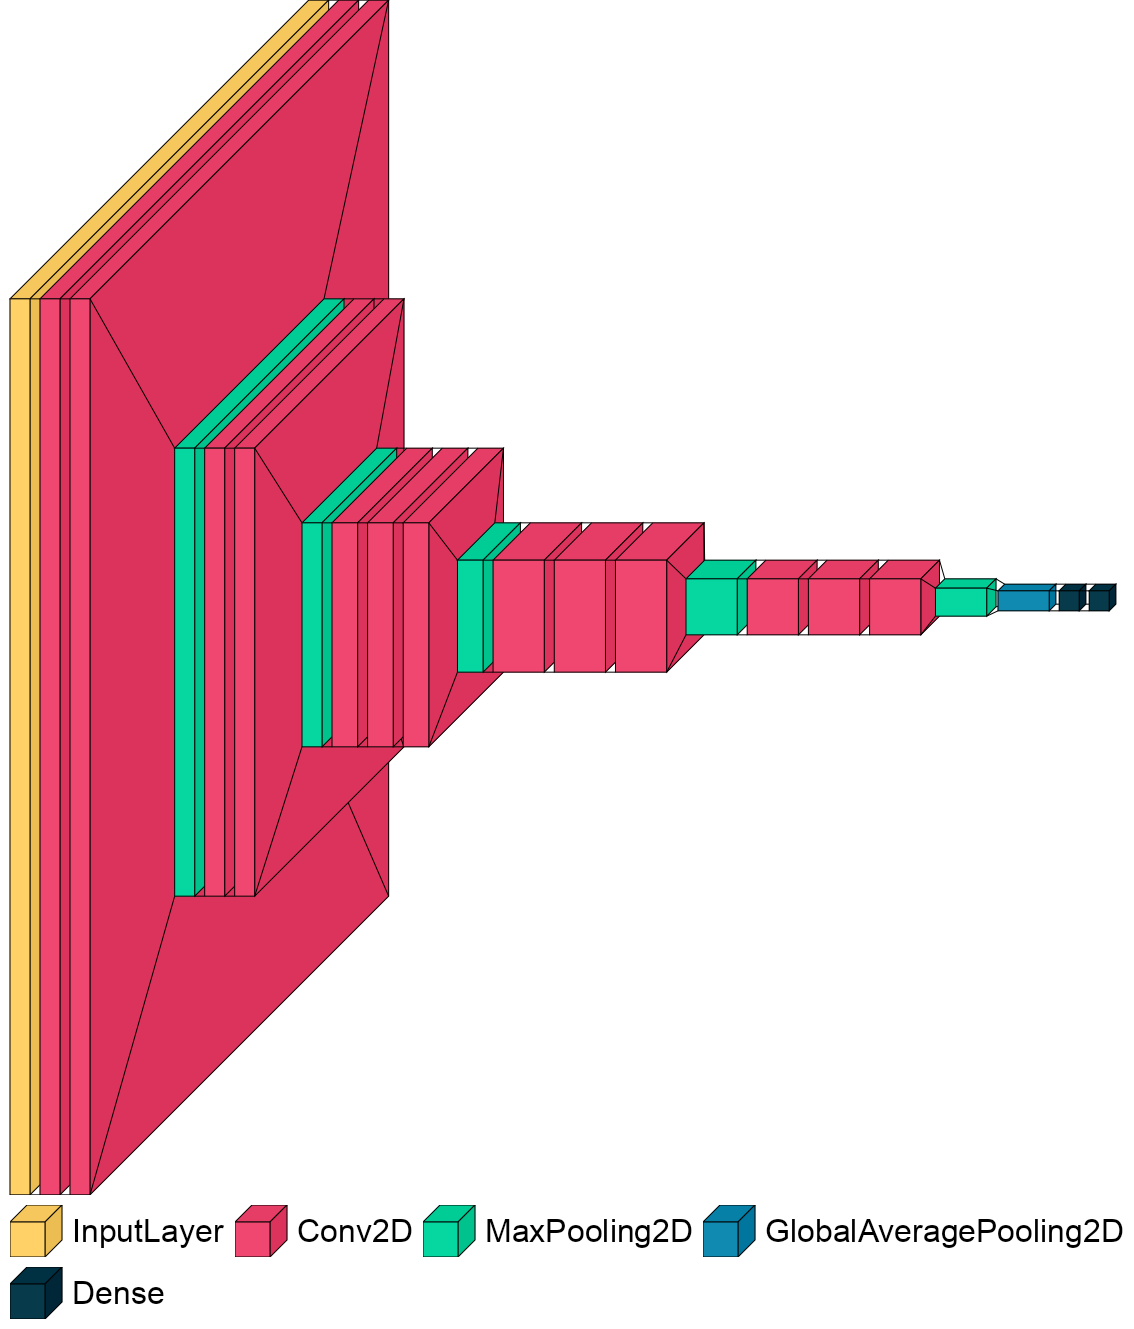

In [78]:
font = ImageFont.truetype("Arial.ttf", 32)
visualkeras.layered_view(VGG_model, legend=True, font=font, max_z=400)

In [79]:
name = './unet_model.h5'
checkp = [EarlyStopping(patience=2),
              ModelCheckpoint(name, monitor = 'accuracy', save_best_only = True, verbose = 1)]
start_time =time.time() # your code here#
VGG_history = VGG_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [checkp]
)

end_time = time.time()
VGG_time =end_time - start_time # Your code here #
VGG_model_parameters = VGG_model.count_params()
# Your code here #

<ipython-input-79-dda3398e9763>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  VGG_history = VGG_model.fit_generator(


Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.7442
Epoch 1: accuracy improved from -inf to 0.74423, saving model to ./unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 92s 351ms/step - loss: 0.5014 - accuracy: 0.7442 - val_loss: 0.4243 - val_accuracy: 0.8047
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8116
Epoch 2: accuracy improved from 0.74423 to 0.81164, saving model to ./unet_model.h5
255/255 [==============================] - 91s 357ms/step - loss: 0.4055 - accuracy: 0.8116 - val_loss: 0.3768 - val_accuracy: 0.8244
Epoch 3/10
255/255 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8369
Epoch 3: accuracy improved from 0.81164 to 0.83691, saving model to ./unet_model.h5
255/255 [==============================] - 89s 350ms/step - loss: 0.3634 - accuracy: 0.8369 - val_loss: 0.3681 - val_accuracy: 0.8443
Epoch 4/10
255/255 [==============================] - ETA: 0s - loss: 0.3406 - accuracy: 0.8527
Epoch 4: accuracy improved from 0.83691 to 0.85265, saving model to ./unet_model.h5
255/255 [==============================] - 102s 398ms/step

In [80]:
VGG_train_acc = VGG_history.history['accuracy'][-1]
VGG_val_acc = VGG_history.history['val_accuracy'][-1]
VGG_train_loss = VGG_history.history['loss'][-1]
VGG_val_loss = VGG_history.history['val_loss'][-1]

now we want to plot:

*   Training Loss
*   Validation Loss
*   Training Accuracy
*   Validation Accuracy
*   Confusion Matrix





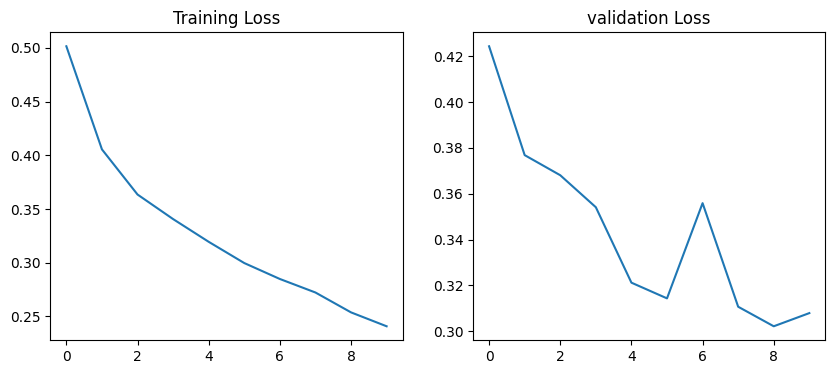

In [81]:
loss_plot(VGG_history)

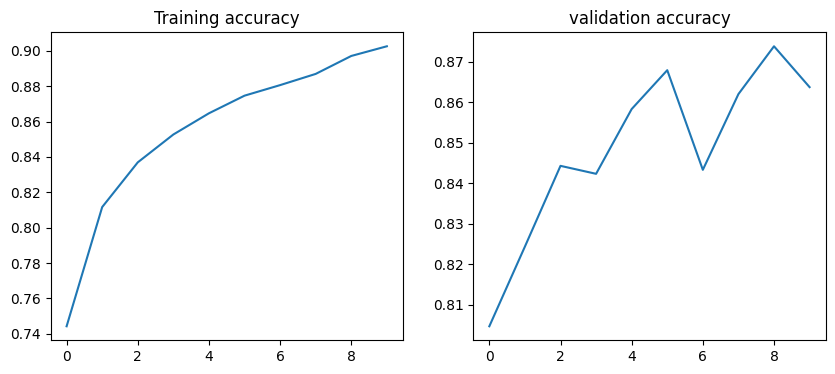

In [82]:
acc_plot(VGG_history)

[[ 987  332]
 [ 222 2525]]


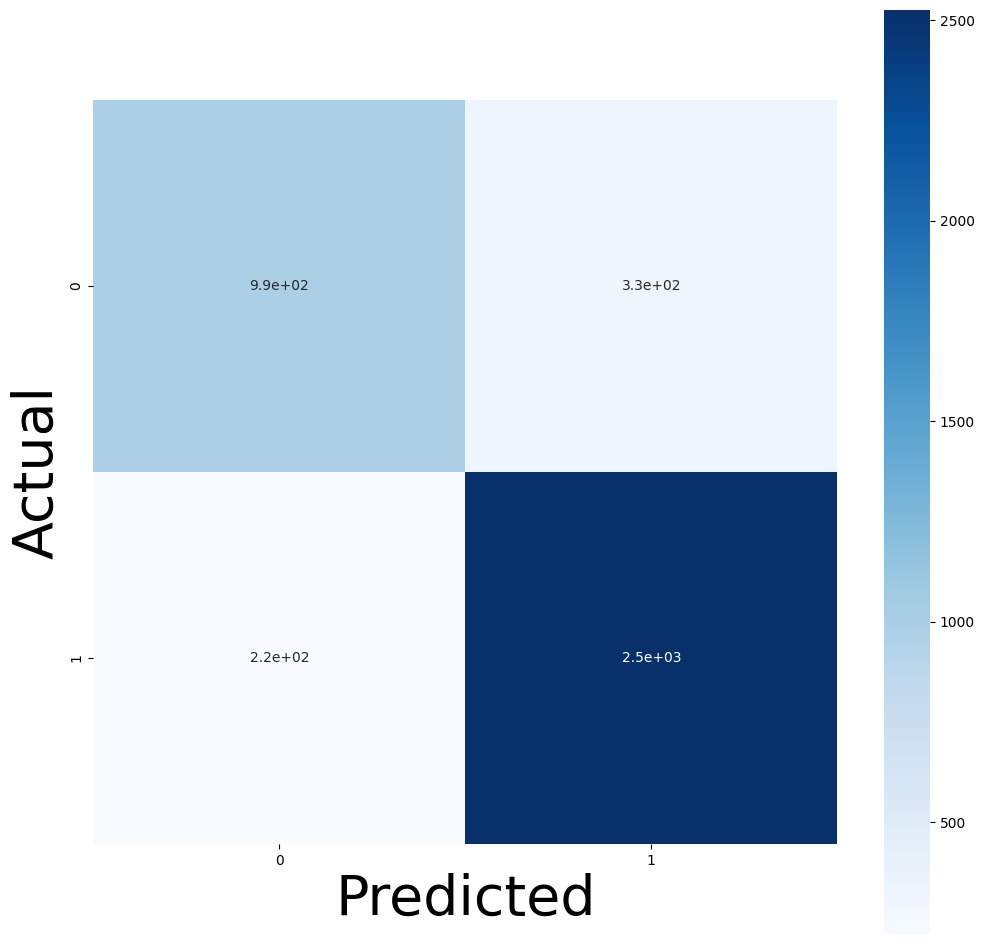

In [83]:
cm_plot(VGG_model)

2/2 [==============================] - 0s 120ms/step


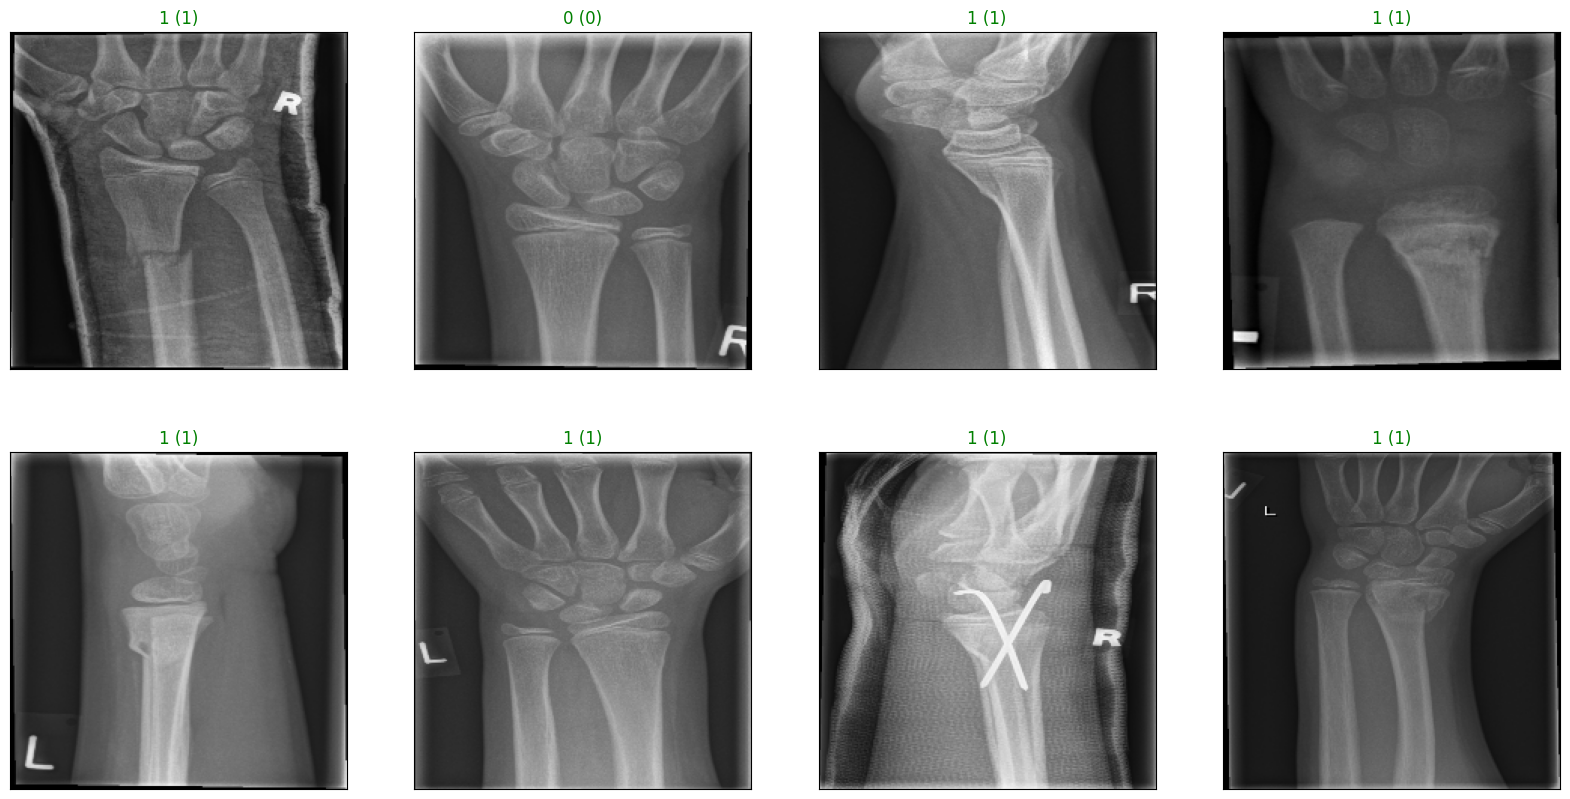

In [84]:
visualizer(val_generator, VGG_model, (20,10), (2,4))

## Resnet

ResNet, short for Residual Network, is a deep convolutional neural network architecture that was introduced by researchers Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their 2015 paper titled "Deep Residual Learning for Image Recognition." It won the 2016 ImageNet competition, demonstrating its effectiveness in image classification tasks.

The key innovation in ResNet is the use of residual blocks, which address the vanishing gradient problem that often occurs in very deep neural networks. The vanishing gradient problem can make it challenging for traditional deep networks to learn effectively as the gradients become extremely small, hindering the training process.

In a residual block, instead of trying to learn the mapping directly, the network learns residual functions. The output of a layer is added to the input, creating a shortcut connection (or "skip connection"). This enables the network to learn the difference or residual between the input and the desired output, making it easier for the network to learn identity mappings. The residual blocks allow the model to efficiently train very deep networks by mitigating the vanishing gradient issue.

The architecture of ResNet consists of multiple residual blocks stacked on top of each other, forming a deep neural network. Different versions of ResNet, such as ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, are based on the number and structure of these residual blocks. We use ResNet-50 in this project.

ResNet has had a significant impact on the field of computer vision and deep learning, especially in image recognition tasks. Its concepts of residual learning and skip connections have been incorporated and adapted in various architectures to improve training and performance in deep neural networks.

In [85]:
resnet50 = keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(size,size,3))
resnet_model = define_model(conv_model)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

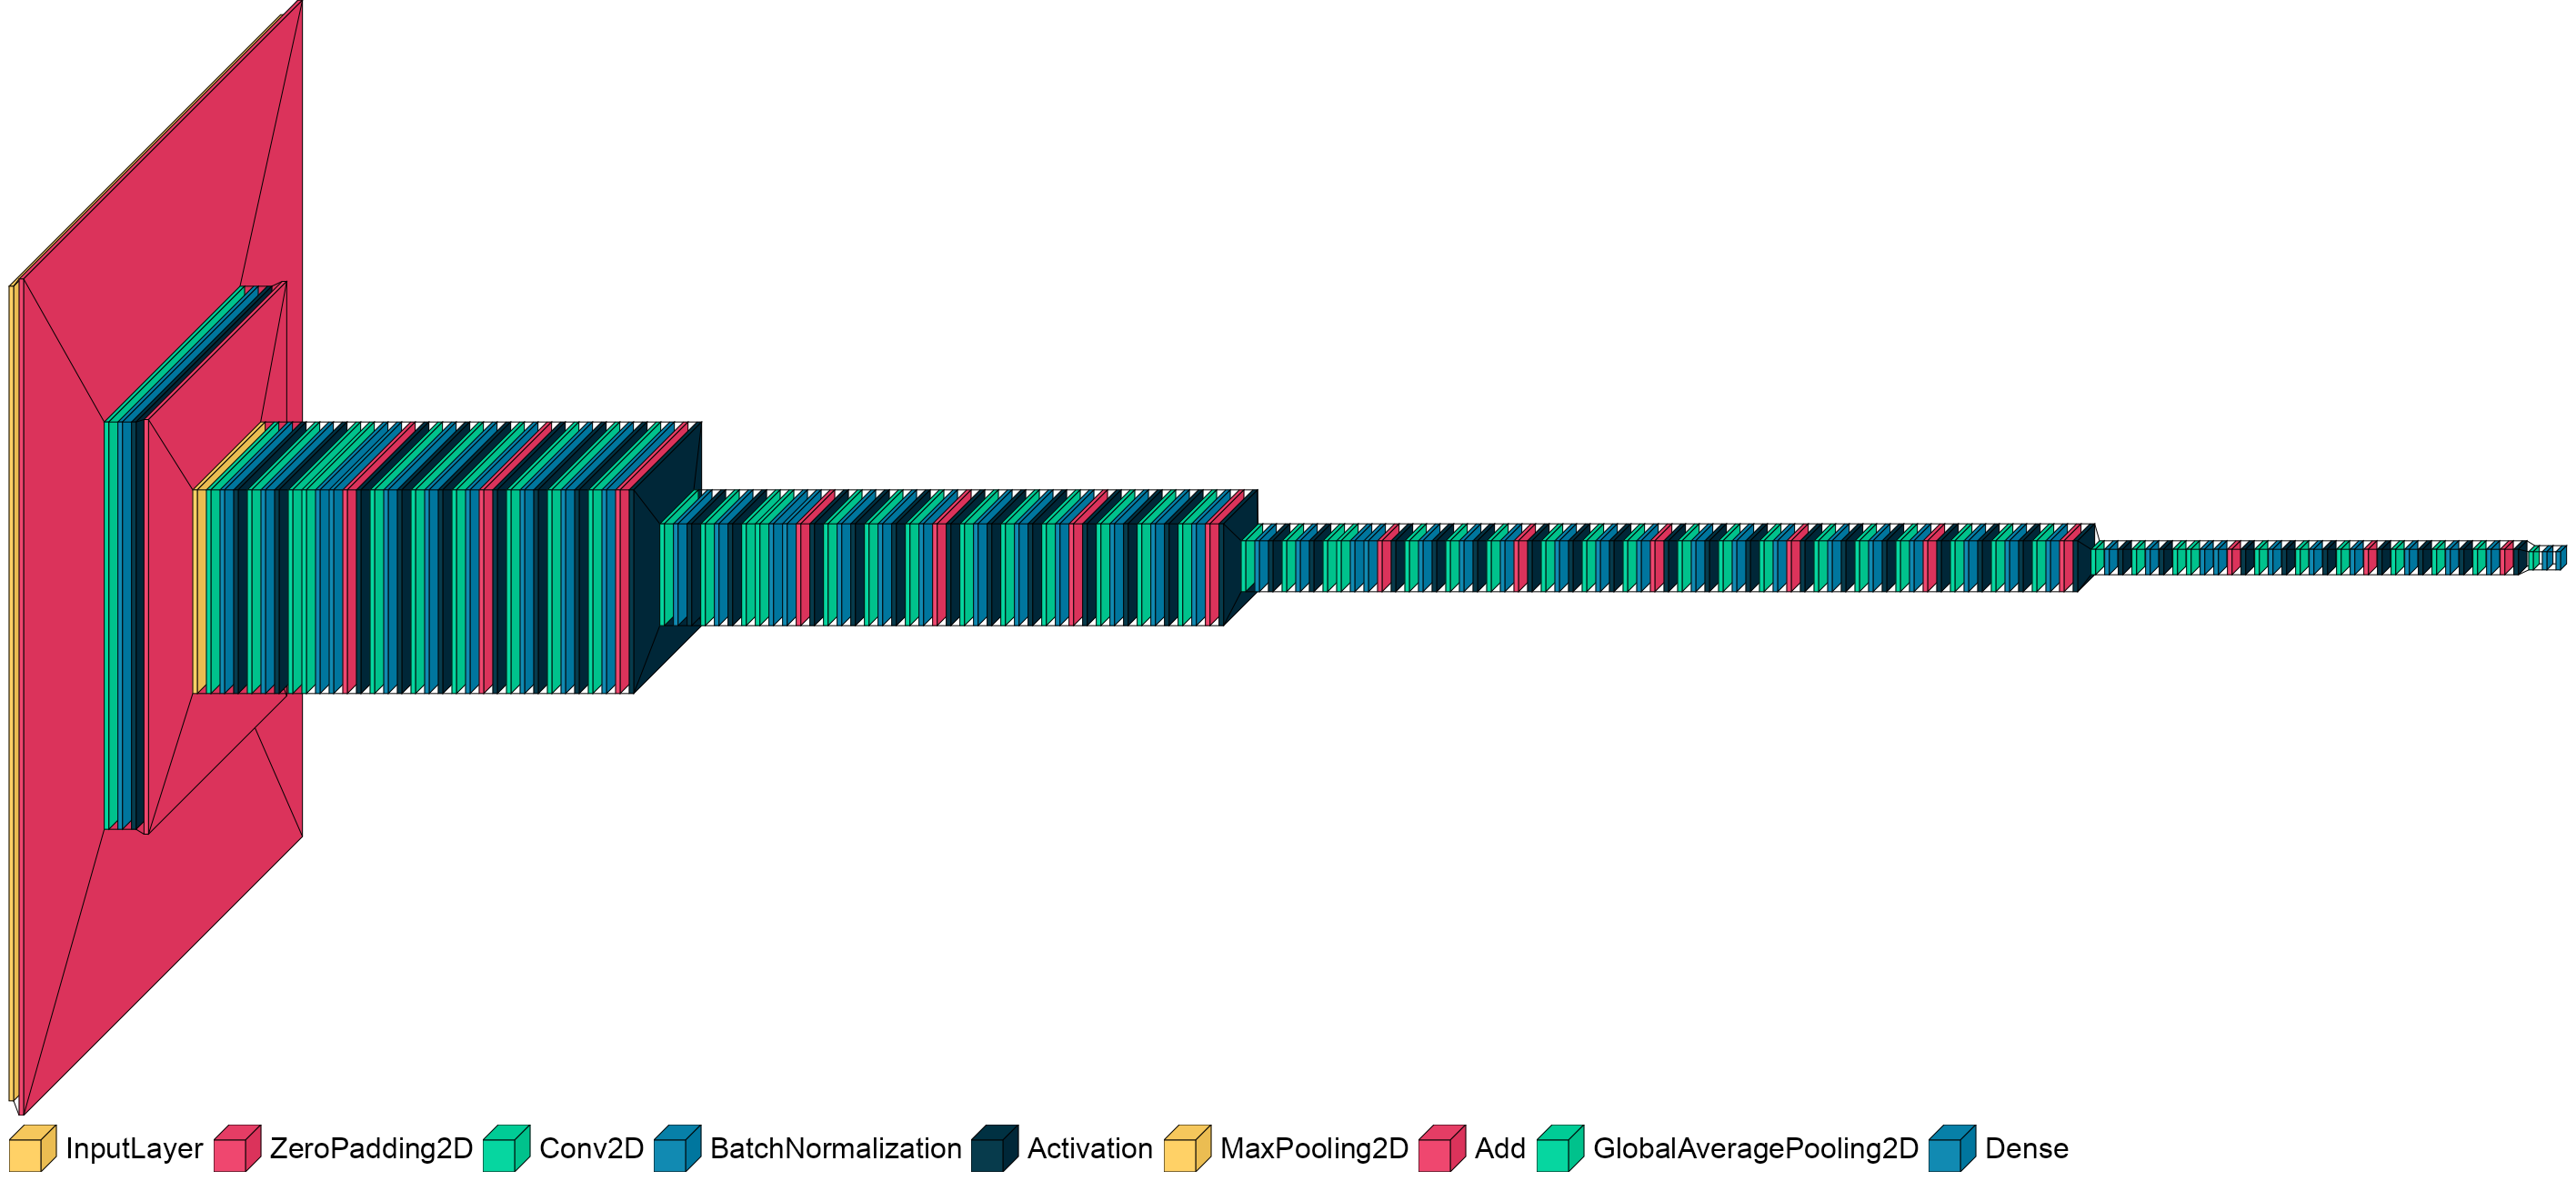

In [86]:
font = ImageFont.truetype("Arial.ttf", 32)
visualkeras.layered_view(resnet_model, legend=True, font=font, max_z=5)

In [87]:
name = './unet_model.h6'
checkp = [EarlyStopping(patience=2),
          ModelCheckpoint(name, monitor='accuracy', save_best_only=True, verbose=1)]

start_time = time.time()

resnet_history = resnet_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=checkp
)

end_time = time.time()
resnet_time = end_time - start_time

resnet_model_parameters = resnet_model.count_params()

<ipython-input-87-588c6404e684>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_history = resnet_model.fit_generator(


Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.6600
Epoch 1: accuracy improved from -inf to 0.66005, saving model to ./unet_model.h6
255/255 [==============================] - 104s 378ms/step - loss: 0.6222 - accuracy: 0.6600 - val_loss: 0.5908 - val_accuracy: 0.6800
Epoch 2/10
255/255 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.6648
Epoch 2: accuracy improved from 0.66005 to 0.66484, saving model to ./unet_model.h6
255/255 [==============================] - 91s 358ms/step - loss: 0.5968 - accuracy: 0.6648 - val_loss: 0.5708 - val_accuracy: 0.6771
Epoch 3/10
255/255 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.6720
Epoch 3: accuracy improved from 0.66484 to 0.67198, saving model to ./unet_model.h6
255/255 [==============================] - 93s 365ms/step - loss: 0.5801 - accuracy: 0.6720 - val_loss: 0.5996 - val_accuracy: 0.6454
Epoch 4/10
255/255 [==============================] - ETA: 0

In [88]:
resnet_train_acc = resnet_history.history['accuracy'][-1]
resnet_val_acc = resnet_history.history['val_accuracy'][-1]
resnet_train_loss = resnet_history.history['loss'][-1]
resnet_val_loss = resnet_history.history['val_loss'][-1]

now we want to plot:

*   Training Loss
*   Validation Loss
*   Training Accuracy
*   Validation Accuracy
*   Confusion Matrix


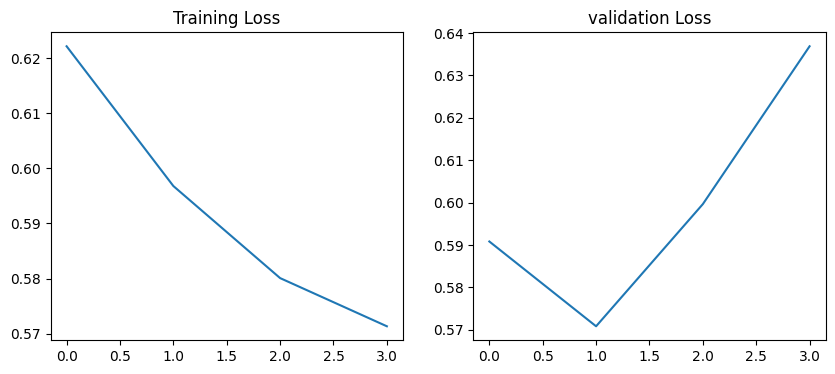

In [89]:
loss_plot(resnet_history)

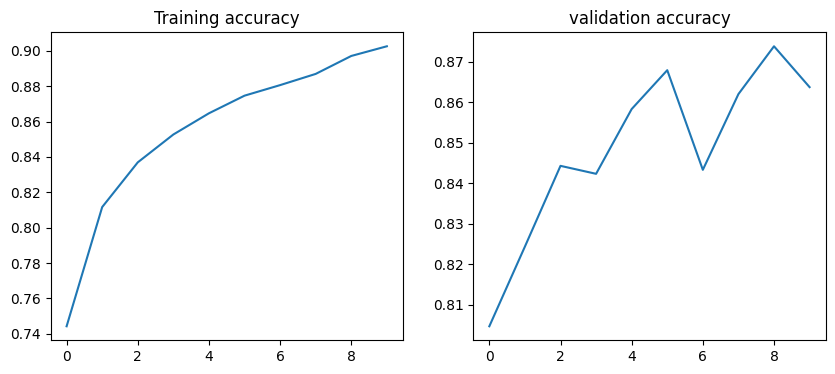

In [96]:
acc_plot(resnet_history)

[[1212  107]
 [1535 1212]]


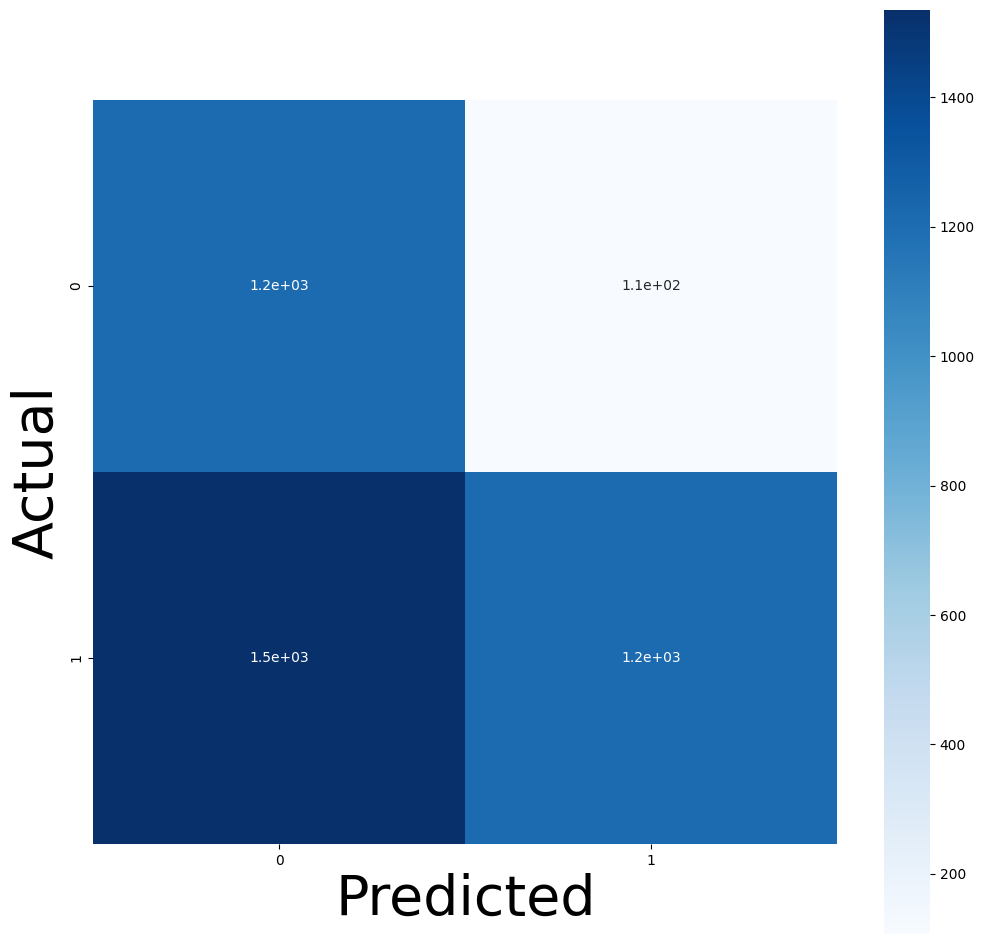

In [95]:
cm_plot(resnet_model)

2/2 [==============================] - 0s 88ms/step


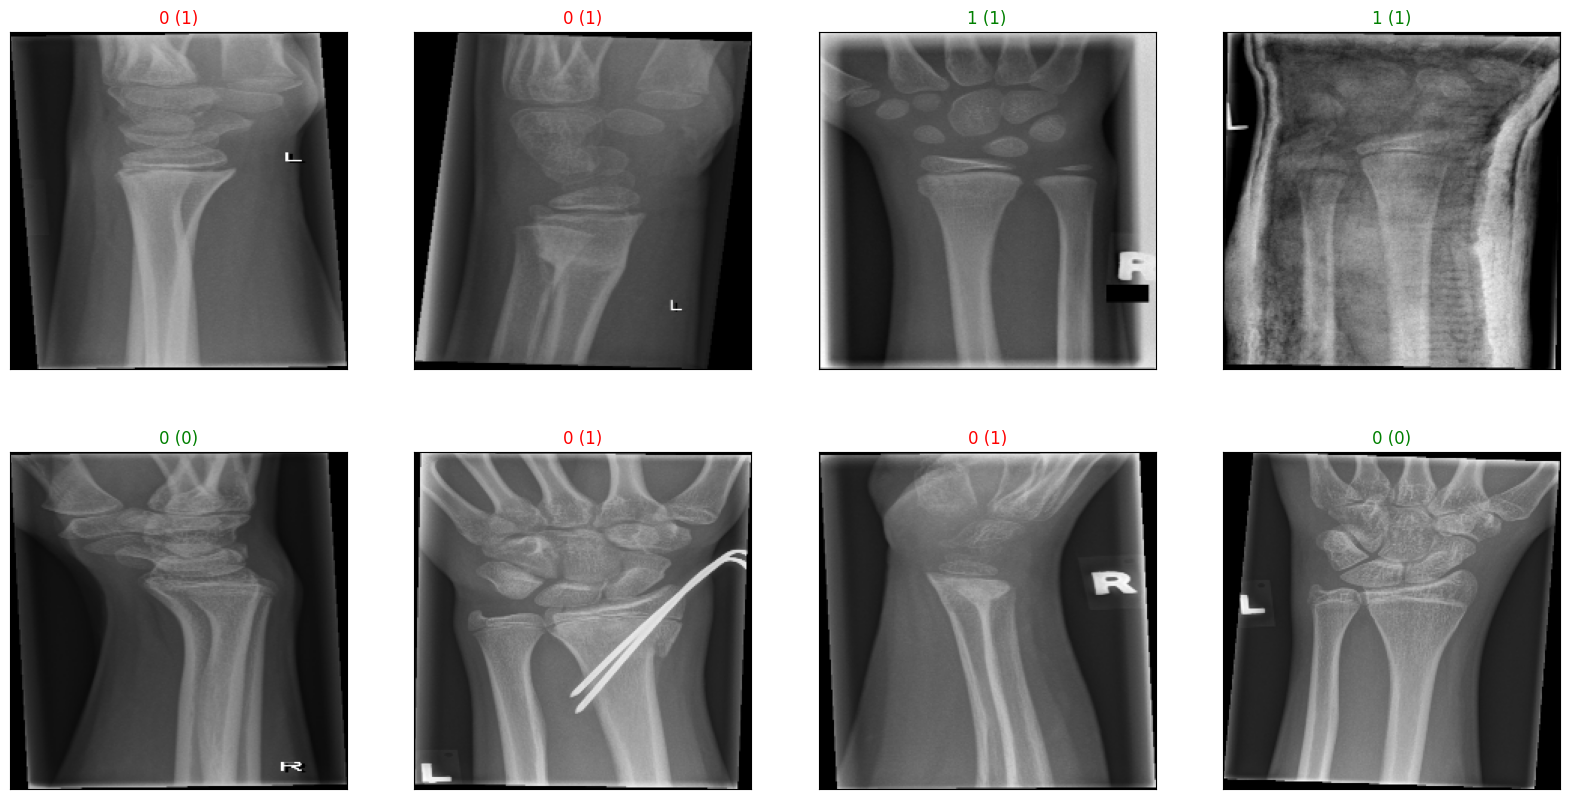

In [92]:
visualizer(val_generator, resnet_model, (20,10), (2,4))

# Conclusion

At the end, we compare the results in the form of a table

In [94]:
myTable = PrettyTable(["model", "number of train data", "number of test data", "train accuracy", "test accuracy", "time", "parametes"])

# Add rows
# Your code here #

myTable.add_row(["VGG", df.shape[0]*0.8, df.shape[0]*0.2, VGG_train_acc, VGG_val_acc, VGG_time, VGG_model_parameters])
myTable.add_row(["resnet", df.shape[0]*0.8, df.shape[0]*0.2, resnet_train_acc, resnet_val_acc, resnet_time, resnet_model_parameters])

print(myTable)

+--------+----------------------+---------------------+--------------------+--------------------+--------------------+-----------+
| model  | number of train data | number of test data |   train accuracy   |   test accuracy    |        time        | parametes |
+--------+----------------------+---------------------+--------------------+--------------------+--------------------+-----------+
|  VGG   |       16261.6        |        4065.4       | 0.9025275111198425 | 0.8637481331825256 | 1143.6945600509644 |  14780610 |
| resnet |       16261.6        |        4065.4       | 0.6768341660499573 | 0.5961633324623108 | 483.8494234085083  |  23850242 |
+--------+----------------------+---------------------+--------------------+--------------------+--------------------+-----------+
